In [1]:
# install requirements. 
!pip install nibabel matplotlib scikit-image numpy

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os
import skimage.color

# run the following line if using jupyter notebook
%matplotlib inline 

/home/sf673542/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def read_nii(subject_path):
    '''
    Function: 
        Load the nifty image data of a subject in Brats dataset
    Input:
        subject_path: the directory where the subject data is stored. 
                The directory should contains '*t1.nii.gz', '*t1ce.nii.gz', '*t2.nii.gz', '*flair.nii.gz', '*seg.nii.gz'
    Output:
        data: a dictionary with keys ['t1', 't1c', 't2', 'flair', 'seg'], each stores the 3D numpy array for
                the corresponding image contrast/mask
    '''
    files = os.listdir(subject_path)
    t1 = [a for a in files if 't1.' in a]
    t1c = [a for a in files if 't1c' in a]
    t2 = [a for a in files if 't2' in a]
    flair = [a for a in files if 'flair' in a]
    seg = [a for a in files if 'seg' in a]
    if len(t1) != 1:
        error('No T1 image found!')
    else:
        t1 = nib.load(os.path.join(subject_path, t1[0])).get_data()
        t1 = (t1 / t1.max() * 255).astype(np.uint8)

    if len(t1c) != 1:
        error('No T1c image found!')
    else:
        t1c = nib.load(os.path.join(subject_path, t1c[0])).get_data()
        t1c = (t1c / t1c.max() * 255).astype(np.uint8)

    if len(t2) != 1:
        error('No T2 image found!')
    else:
        t2 = nib.load(os.path.join(subject_path, t2[0])).get_data()
        t2 = (t2 / t2.max() * 255).astype(np.uint8)

    if len(flair) != 1:
        error('No FLAIR image found!')
    else:
        flair = nib.load(os.path.join(subject_path, flair[0])).get_data()
        flair = (flair / flair.max() * 255).astype(np.uint8)

    if len(seg) != 1:
        error('No segmentation image found!')
    else:
        seg = nib.load(os.path.join(subject_path, seg[0])).get_data()
#         seg = (seg > 0).astype(np.uint8)
        
    data = {'t1':t1, 't1c':t1c, 't2':t2, 'flair':flair, 'seg':seg}
    return data

In [4]:
# I just selected a random subject from Brats2017 dataset for demo
data = read_nii('/bigdisks/ucsf/anisotropic_nets/visualize_results/Brats17_CBICA_ABT_1')

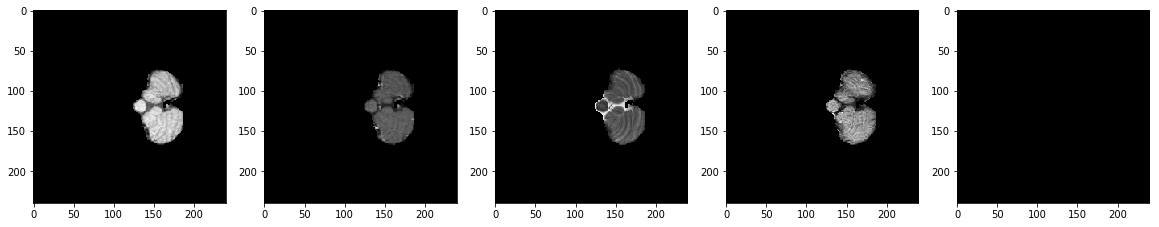

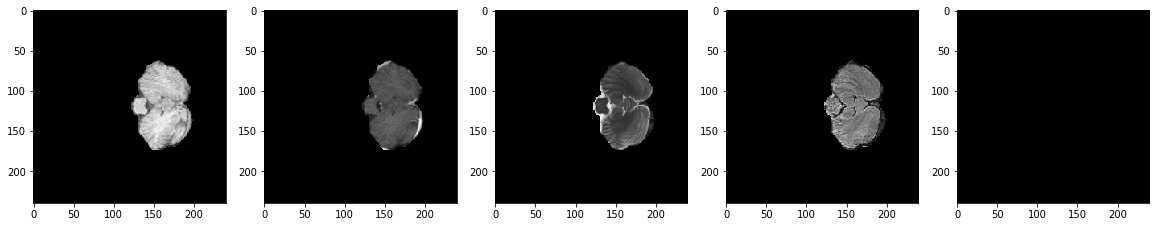

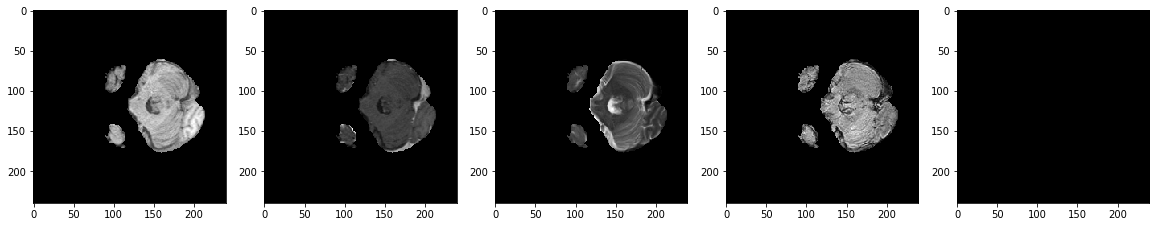

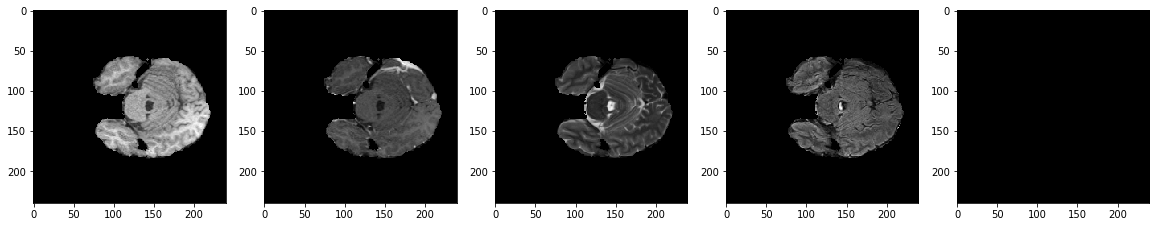

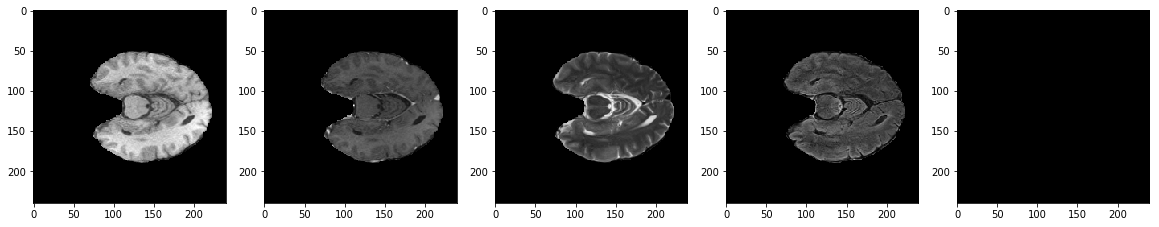

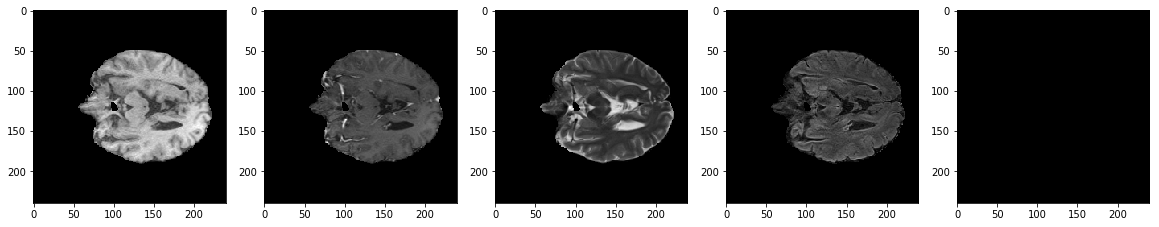

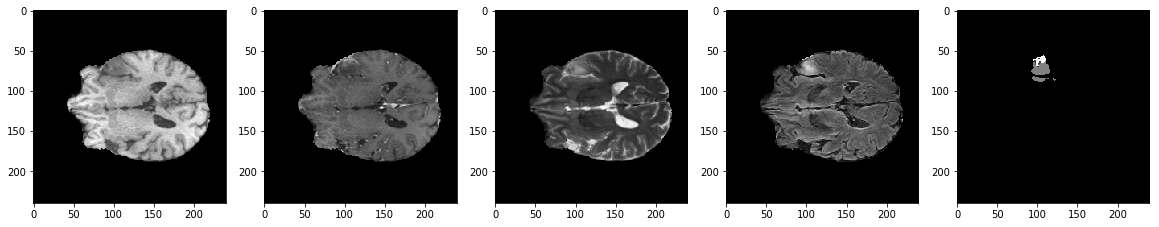

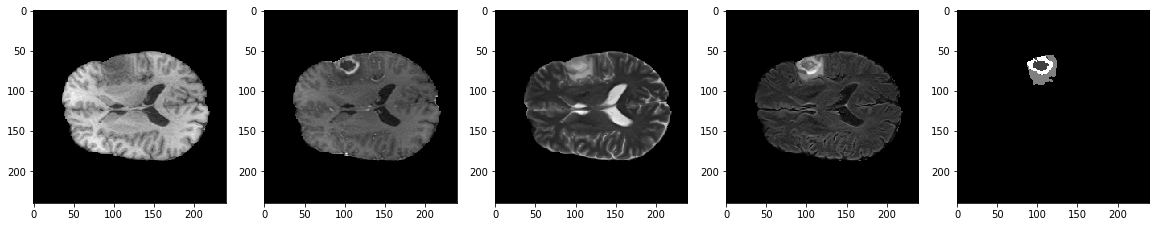

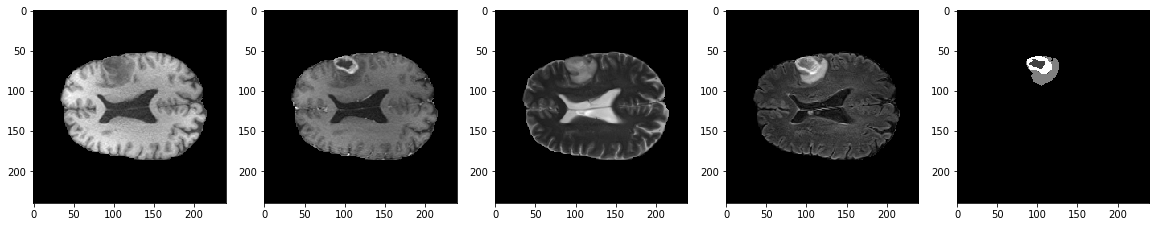

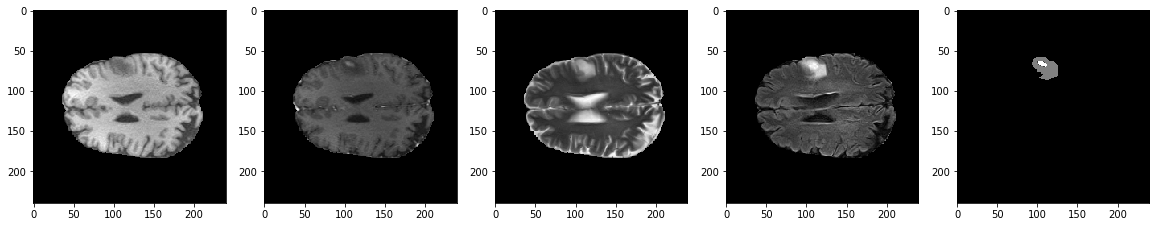

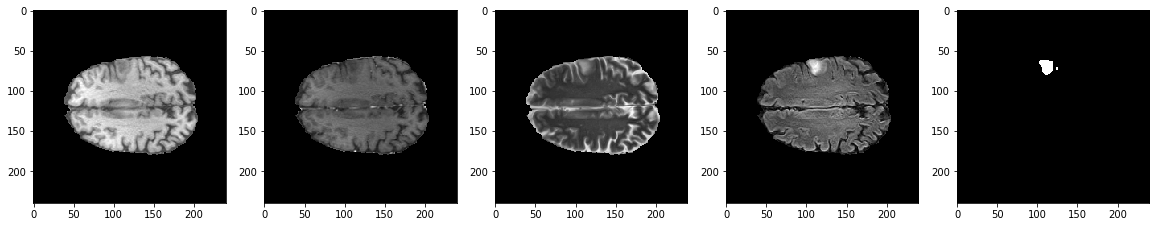

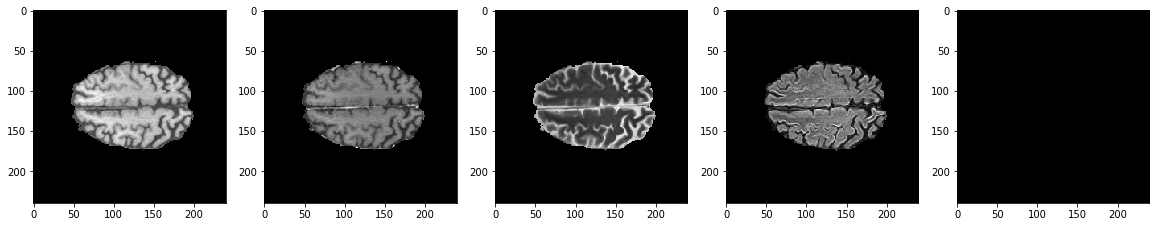

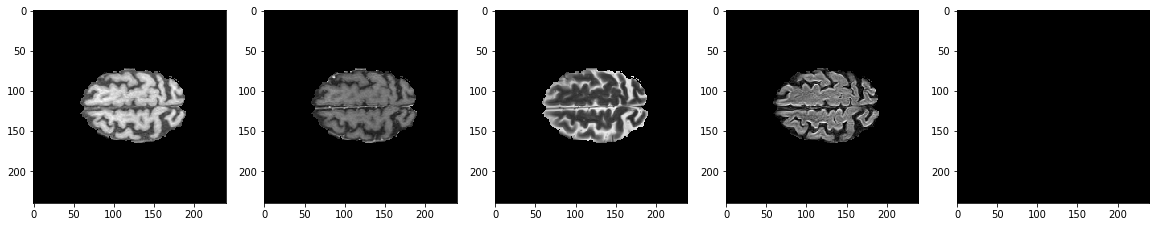

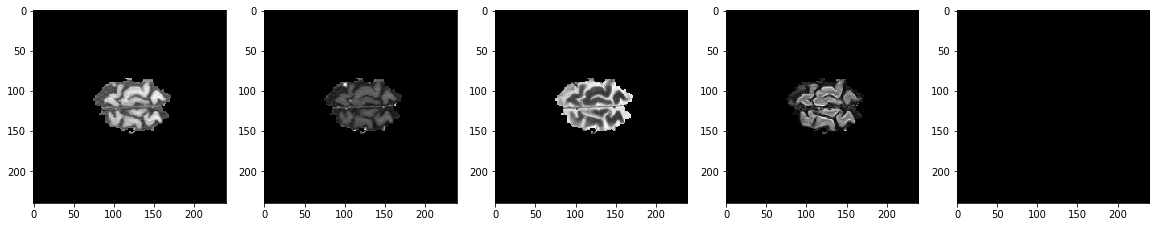

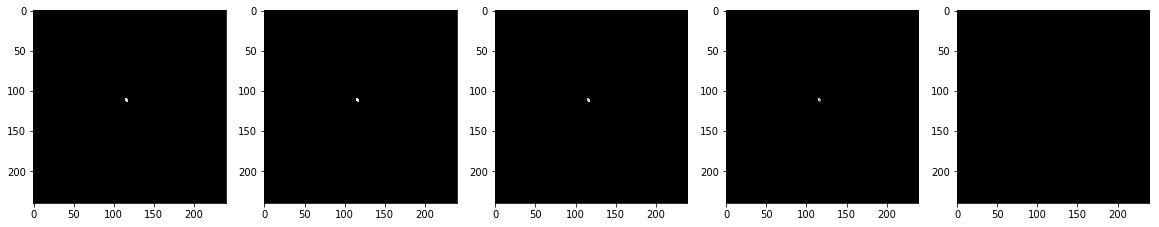

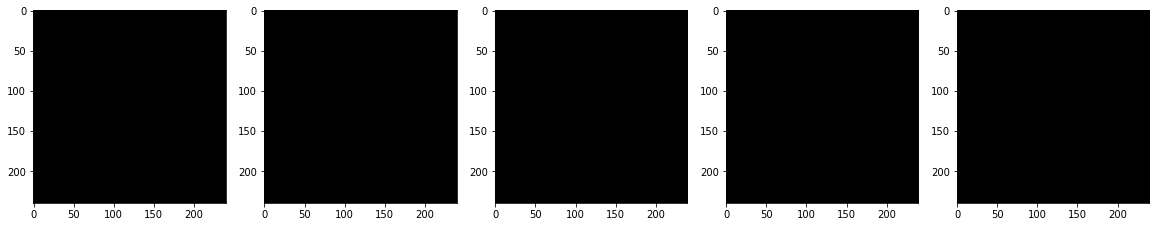

In [5]:
# view the data
for z in range(0, 155, 10):
    plt.figure(figsize=(20, 4))
    plt.subplot(151)
    plt.imshow(data['t1'][:,:,z], cmap='gray')
    plt.subplot(152)
    plt.imshow(data['t1c'][:,:,z], cmap='gray')
    plt.subplot(153)
    plt.imshow(data['t2'][:,:,z], cmap='gray')
    plt.subplot(154)
    plt.imshow(data['flair'][:,:,z], cmap='gray')
    plt.subplot(155)
    plt.imshow(data['seg'][:,:,z], cmap='gray')

In [6]:
def overlay_img_mask(img, mask, alpha=0.5):
    '''
    Function: 
        Overlay the mask to gray-scale image and display the mask in color
    Input:
        img: the gray-scale input image
        mask: the mask you want to overlay to the gray image
        alpha: the mask overlay intensity. float in [0, 1], default=0.5.
    Output:
        An overlayed RGB image where the mask is shown in color and the image is gray.
    '''
    img_rgb = (skimage.color.grey2rgb(img/(img.max()+1e-15)) * 255).astype(np.uint8)

    colors = [[0,255,255], [255,0,0], [0,255,0], [0, 0, 255]] # specify colors
    maskLevel = list(set(mask.ravel()))
    if len(maskLevel) > 20:
        raise ValueError("Too many values found on mask. May by a wrong input.")
    mask3 = img_rgb.copy()
    for i, level in enumerate(maskLevel): 
        if level != 0:
            mask3[mask == level,:] = colors[i % len(colors)]
    img_overlay = img_rgb * (1 - alpha) + mask3 * alpha # alpha ~= mask opacity?
    img_overlay = img_overlay.astype(np.uint8)

    return img_overlay

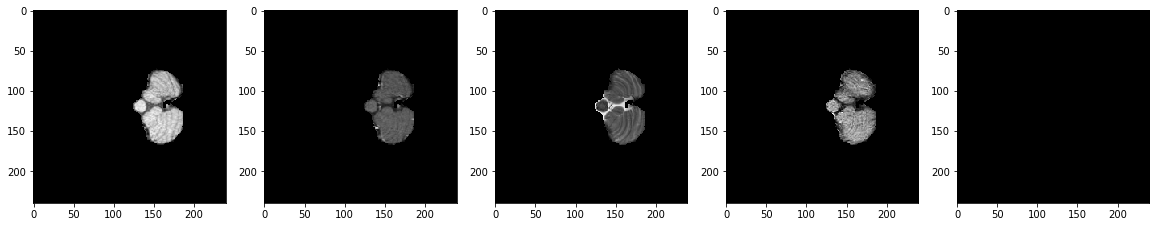

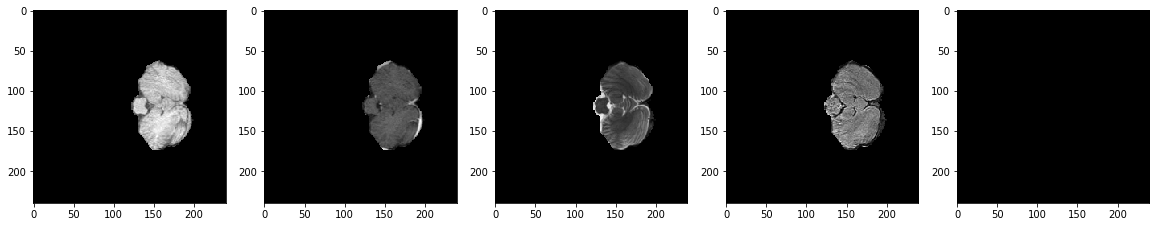

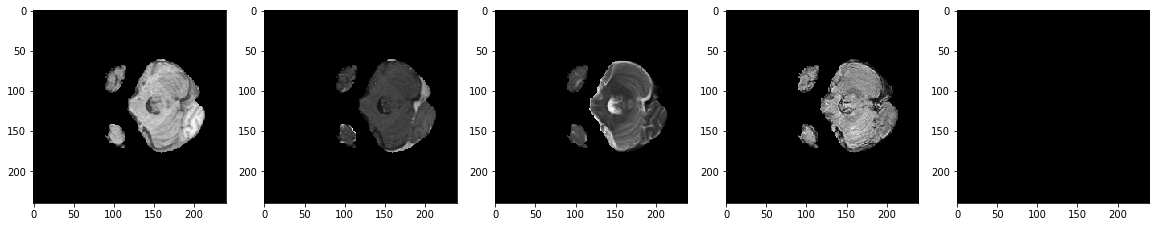

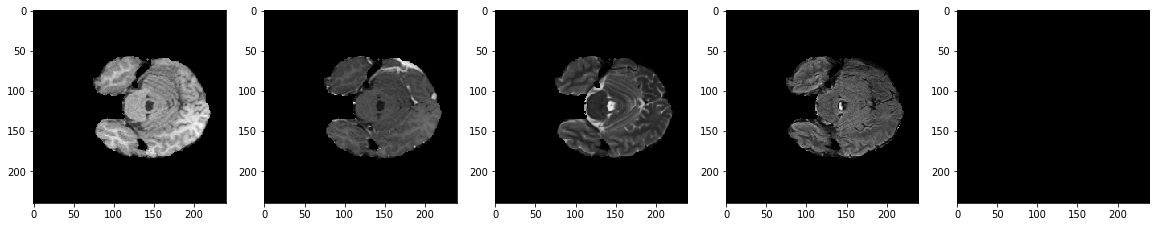

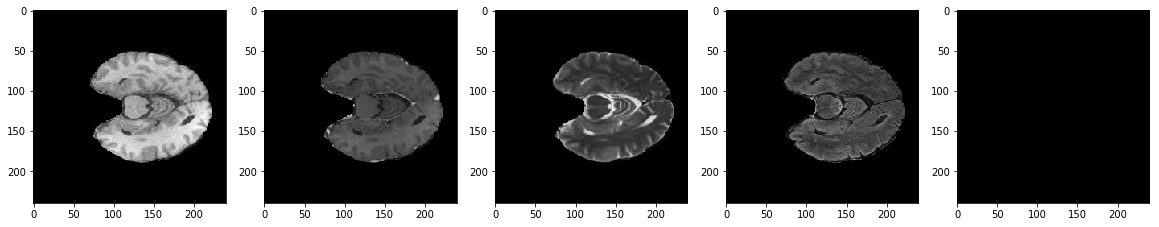

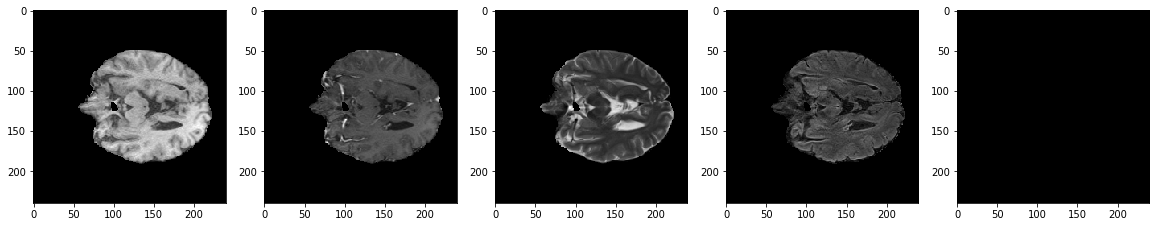

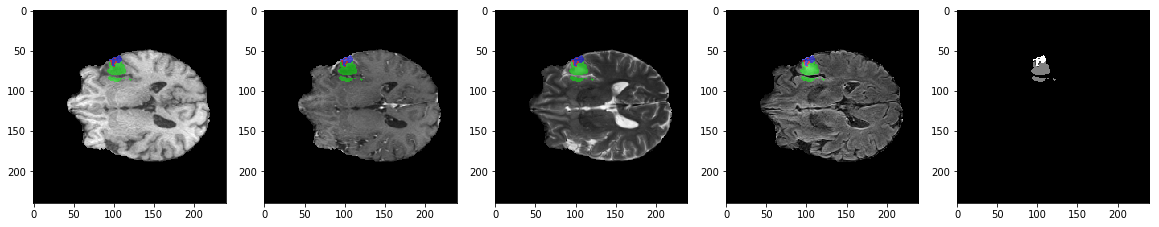

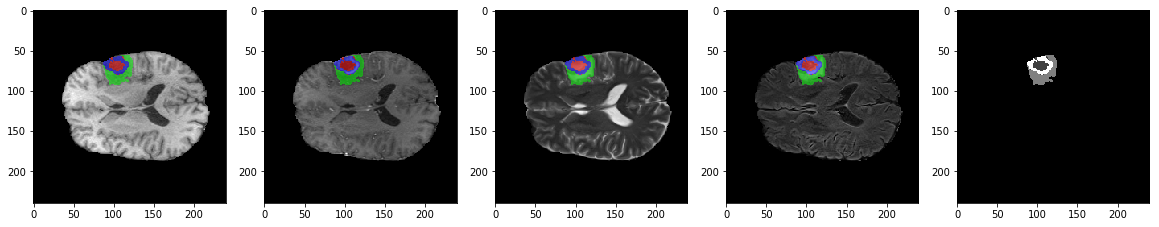

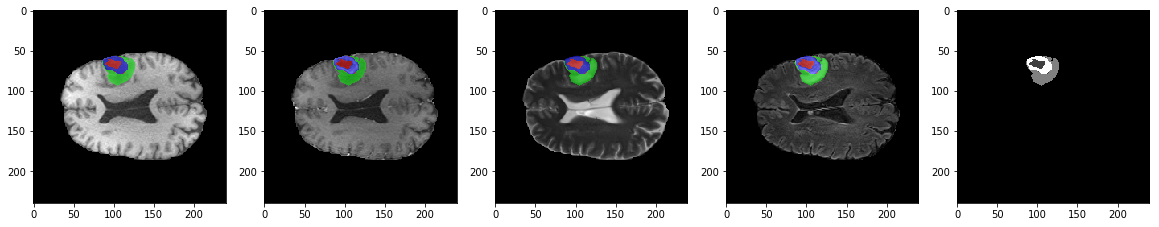

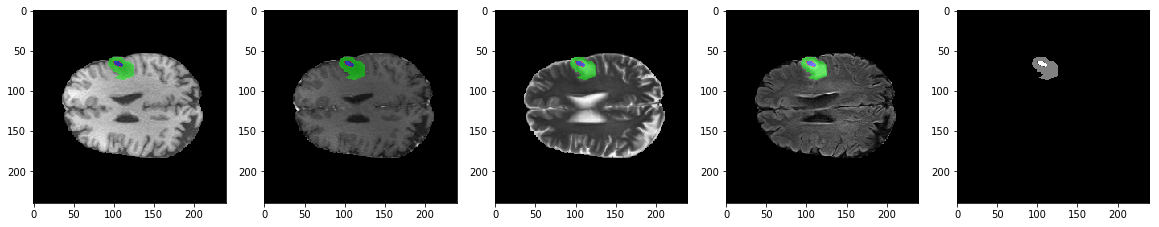

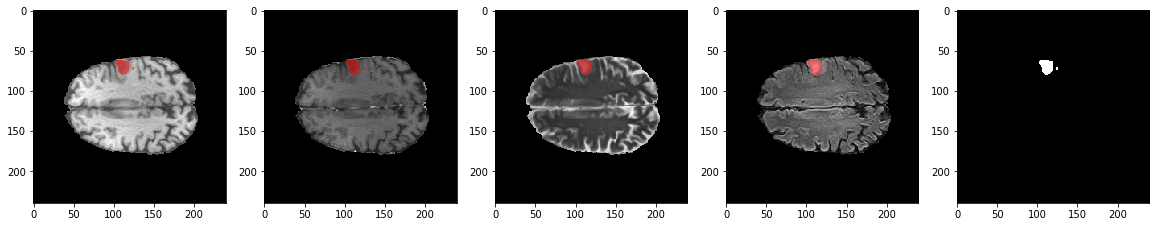

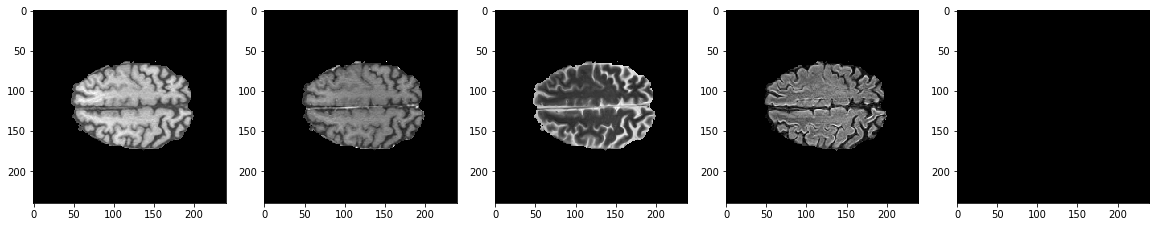

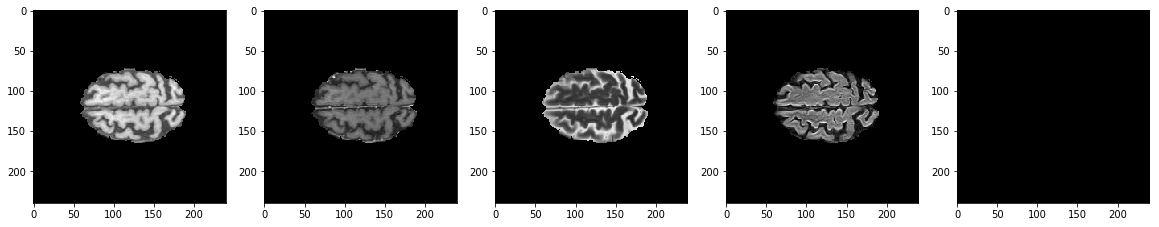

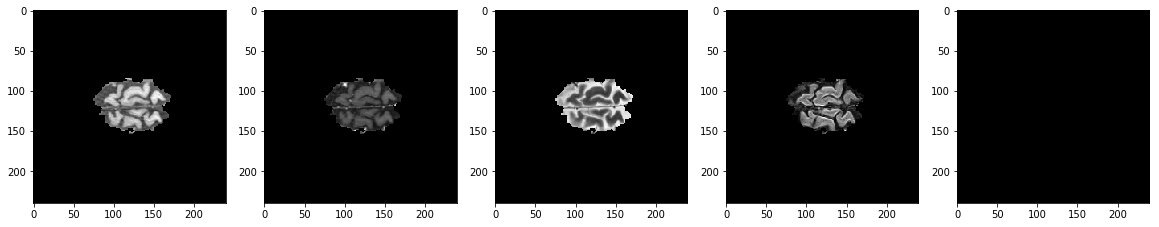

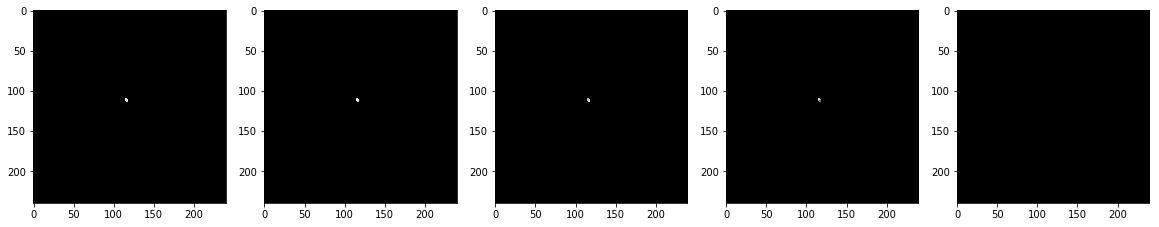

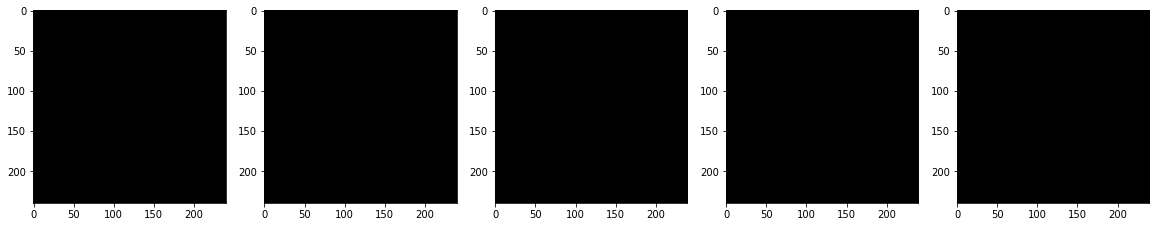

In [7]:
# overlay the mask to the image and display
for z in range(0, 155, 10):
    plt.figure(figsize=(20, 4))
    plt.subplot(151)
    plt.imshow(overlay_img_mask(data['t1'][:,:,z], data['seg'][:,:,z]))
    plt.subplot(152)
    plt.imshow(overlay_img_mask(data['t1c'][:,:,z], data['seg'][:,:,z]))
    plt.subplot(153)
    plt.imshow(overlay_img_mask(data['t2'][:,:,z], data['seg'][:,:,z]))
    plt.subplot(154)
    plt.imshow(overlay_img_mask(data['flair'][:,:,z], data['seg'][:,:,z]))
    plt.subplot(155)
    plt.imshow(data['seg'][:,:,z], cmap='gray')
# Note: don't use cmap='gray' here because images are already converted to rgb mode

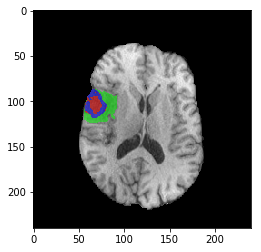

In [8]:
# Some note: 
# Matplotlib display the first dimension in vertical and second dimension in horizontal direction,
# but in nifty data the first dimension usually corresponds to the horizontal axis (physical x-axis). 
# So in convention the 2D image should be displayed as follows: 
plt.imshow(np.transpose(overlay_img_mask(data['t1'][:,:,70], data['seg'][:,:,70]), (1,0,2)))